# Used cars prices analysis and prediction

In this project, we are going to use three machine learning algorithm to do the prediction:
Multiple Linear Regression with LASSO panelty;
Random Forest;
XGboost

In [6]:
# import any tool if needed
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as ss
from scipy.optimize import minimize
import pandas as pd 
import numpy as np
import seaborn as sns

import sklearn as sk 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Dataset Manipulation

In [7]:
df = pd.read_csv('cars_11_18.csv')
df.head

<bound method NDFrame.head of        Unnamed: 0  Unnamed: 0.1  price    year manufacturer     model  \
0               1             5  13995  2012.0         ford     f-150   
1               2             6   7995  2010.0    chevrolet   equinox   
2               3             7   8995  2011.0    chevrolet  traverse   
3               4             8  10995  2014.0         ford  explorer   
4               5             9  12995  2004.0          ram      2500   
...           ...           ...    ...     ...          ...       ...   
19557       61918        423777   5000  2009.0       toyota   corolla   
19558       61923        423803  25871  2017.0         ford  explorer   
19559       61928        423821  12995  2014.0       subaru   outback   
19560       61929        423823   9584  2012.0       toyota     camry   
19561       61930        423824   1000  2004.0         ford     f-150   

       condition    cylinders    fuel  odometer title_status transmission  \
0           good

In [8]:
# elminate duplicate rows and set the price limits to >50 and < 79980

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df.drop_duplicates()

df = df[df.price <79980]
df = df[df.price > 50]

df.head
#df.shape

<bound method NDFrame.head of        price    year manufacturer     model  condition    cylinders    fuel  \
0      13995  2012.0         ford     f-150       good  6 cylinders     gas   
1       7995  2010.0    chevrolet   equinox       good  4 cylinders     gas   
2       8995  2011.0    chevrolet  traverse       good  6 cylinders     gas   
3      10995  2014.0         ford  explorer       good  6 cylinders     gas   
4      12995  2004.0          ram      2500       good  6 cylinders  diesel   
...      ...     ...          ...       ...        ...          ...     ...   
19557   5000  2009.0       toyota   corolla       good  4 cylinders     gas   
19558  25871  2017.0         ford  explorer  excellent  6 cylinders     gas   
19559  12995  2014.0       subaru   outback  excellent  4 cylinders     gas   
19560   9584  2012.0       toyota     camry  excellent  4 cylinders     gas   
19561   1000  2004.0         ford     f-150       fair  8 cylinders     gas   

       odometer title

# Insight of predictors and Data Visualization

Histogram of response/major predictors

# Methods
Multiple Linear Regression with Lasso panelty/ Random forest / XGboost

In [9]:
# Multiple linear regression code
from sklearn.metrics import mean_absolute_error, r2_score
# Multiple linear regression code
data=df #Load the data
data = data.assign(year2 = data.year**2)
data = data.assign(odometer2 = data.odometer**2)
data = data.assign(lnOdomter = np.log(data.odometer+1))
data_dummy = pd.get_dummies(data) #get dummies for categorical variables
Xtrain, Xtest, ytrain, ytest = train_test_split(data_dummy.iloc[:, 1:], data_dummy['price'], test_size=0.25, random_state=0)

#Lets first try a linear model with all features
linear_model = Pipeline([
    ('linear_regression', LinearRegression())
])
kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(mean_absolute_error)
print(cross_val_score(linear_model, Xtrain, ytrain, cv=kf, scoring=sc).mean())
#Not great lets try to improve on this error by adding more terms We will first add interaction only terms


3548.4714637137777


In [10]:
#Back ward selection removed variables
data_fs = data #Full model
data_fs = data_fs.drop(['odometer2'],axis=1)#First removal
data_fs = data_fs.drop(['paint_color'],axis=1) # second removal
data_fs = data_fs.drop(['manufacturer'],axis=1) # third removal

['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
['price', 'odometer']
      year         price
                    mean
0   2000.0   4664.023256
1   2001.0   4640.145110
2   2002.0   5207.703704
3   2003.0   5437.128492
4   2004.0   6210.379209
5   2005.0   6186.873385
6   2006.0   8005.791277
7   2007.0   7387.309592
8   2008.0   9225.525570
9   2009.0   8039.509009
10  2010.0   9324.161002
11  2011.0  11070.032216
12  2012.0  11724.986815
13  2013.0  13783.539955
14  2014.0  14622.337849
15  2015.0  18584.741310
16  2016.0  19094.360689
17  2017.0  22959.329630
18  2018.0  24881.927132
19  2019.0  28086.332579
20  2020.0  34203.173913
   manufacturer         price
                         mean
0           bmw  11883.194175
1         buick  14457.606299
2      cadillac  18377.315789
3     chevrolet  14613.156896
4      chrysler   6848.048980
5         dodge  10971.994643
6          ford  14658.

In [11]:
#The dummie varibles cause the interaction terms too be too large
#We are going to remove features in order to add interaction terms to the model
Xtrain, Xtest, ytrain, ytest = train_test_split(data_fs.iloc[:, 1:], data['price'], test_size=0.25, random_state=0)

columns = list(Xtrain.columns.values)
drop_list = []
for i in columns:
    x_reduced = Xtrain.drop([i],axis=1)
    x_reduced = pd.get_dummies(x_reduced)
    drop_list.append(i)
    drop_list.append(cross_val_score(linear_model, x_reduced, ytrain, cv=kf, scoring=sc).mean())
print(drop_list)
#Full model MAE = 3548.4
#Linear model without odometer2 3380.6
#Linear model without paint_colour 3376.3
#linear model without manufacturer 3376.3

['year', 3560.0599321614145, 'model', 3771.9581514223855, 'condition', 3406.3918868457813, 'cylinders', 375477.1486322937, 'fuel', 3396.713257001401, 'odometer', 581688.5260577824, 'title_status', 3394.8661765758543, 'transmission', 3377.317116165091, 'drive', 3433.831832741345, 'size', 3377.2688859826158, 'type', 1141454.0028425523, 'year2', 3561.465922643935, 'lnOdomter', 3390.2028372209825]


In [12]:
#Fit a full linear model with the reduced data frame
data_fs = pd.get_dummies(data_fs) #get dummies for categorical variables
Xtrain, Xtest, ytrain, ytest = train_test_split(data_fs.iloc[:, 1:], data['price'], test_size=0.25, random_state=0)
#Lets first try a linear model with all features
linear_model = Pipeline([
    ('linear_regression', LinearRegression())
])
kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(mean_absolute_error)
print(cross_val_score(linear_model, Xtrain, ytrain, cv=kf, scoring=sc).mean())

3376.3198905936406


In [13]:
#Fit the data on the test data
regression_model = linear_model.fit(Xtrain,ytrain)
predictions = regression_model.predict(Xtest)
Mean_absolute_error = np.mean(abs(ytest-predictions))
print("The mean absolute error is: " + str(Mean_absolute_error))
print(r2_score(ytest.values, predictions))

The mean absolute error is: 3312.698192197587
0.7628408385533394


In [40]:
# Random forest code

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

df = pd.get_dummies(data = df)

Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:, 1:], df['price'], test_size=0.25, random_state=0)

rf_1 =  RandomForestRegressor(n_estimators=100,
                           criterion='mse',
                           max_depth=None,
                           min_samples_split=2,
                           min_samples_leaf=0.0001,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0001,
                           bootstrap=True,
                           oob_score=True,
                           n_jobs=-1,
                           random_state=0,
                           verbose=0,
                           warm_start=True
                          )

rf_1.fit(Xtrain, ytrain)
predict_rf_1 = rf_1.predict(Xtest)
rf_mf1_accuracy = rf_1.score(Xtest, ytest)
print(mean_absolute_error(ytest.values, predict_rf_1))
print(r2_score(ytest.values, predict_rf_1))


rf_2 =  RandomForestRegressor(n_estimators=200,
                           criterion='mse',
                           max_depth=None,
                           min_samples_split=2,
                           min_samples_leaf=0.0001,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0001,
                           bootstrap=True,
                           oob_score=True,
                           n_jobs=-1,
                           random_state=0,
                           verbose=0,
                           warm_start=True
                          )

rf_2.fit(Xtrain, ytrain)
predict_rf_2 = rf_max3.predict(Xtest)

print(mean_absolute_error(ytest.values, predict_rf_2))
print(r2_score(ytest.values, predict_rf_2))


1651.1462911720716
0.9140702921959201
0.9140702921959201
1648.3694294551567
0.9136829581350028


In [104]:
### RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap}
# use random search to find out best hyper parameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(Xtrain, ytrain)
rf_random.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 46.9min finished


{'n_estimators': 1577, 'max_features': 'sqrt', 'bootstrap': False}

In [105]:
# See how we improved our random forest model

# set rf_1 as base model
print("Base model performance")
print("Mean absolute error is", mean_absolute_error(ytest.values, predict_rf_1))
print("Accuracy is", r2_score(ytest.values, predict_rf_1))

# impoved model
predict_rf_random = rf_random.predict(Xtest)
print("Random model performance")
print("Mean absolute error is", mean_absolute_error(ytest.values, predict_rf_random))
print("Accuracy is", r2_score(ytest.values, predict_rf_random))

# improvement
print('Improvement of {:0.2f}%.'.format( 100 * (r2_score(ytest.values, predict_rf_random)
                                                - r2_score(ytest.values, predict_rf_1)) / 
                                       r2_score(ytest.values, predict_rf_1)))

Base model performance
Mean absolute error is 1651.1462911720716
Accuracy is 0.9140702921959201
Random model performance
Mean absolute error is 1467.4517560463453
Accuracy is 0.9160111371585241
Improvement of 0.21%.


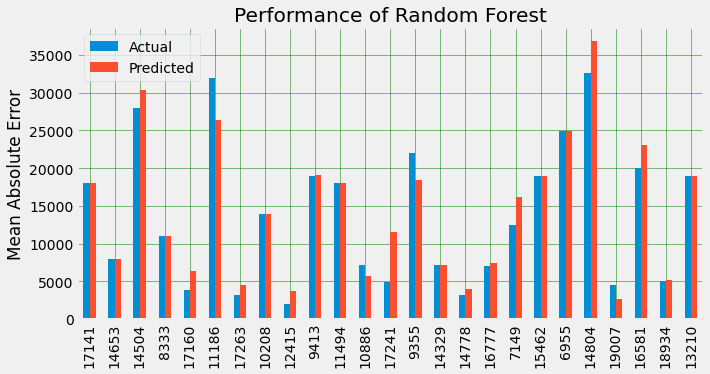

In [106]:
y_pred = rf_random.predict(Xtest)
df_check = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Absolute Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()
 


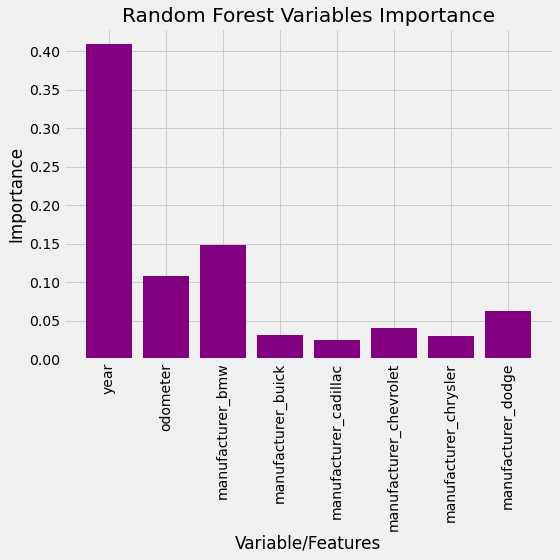

In [107]:

importances = rf_1.feature_importances_
features=Xtrain.columns
importances = importances[importances!=0]
importances = importances[importances > 0.025]
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(8,8))
plt.bar(x_values, importances, orientation = ('vertical'),color = 'purple')
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.show();



In [15]:

# XGboost code

(18208, 14)
(18208, 176)


In [16]:
# XGboost code
Xtrain, Xtest, ytrain, ytest = train_test_split(data.iloc[:, 1:], data['price'], test_size=0.25, random_state=0)

from xgboost import XGBRegressor
XGB = XGBRegressor(max_depth=5,
                   learning_rate=0.2,
                   n_estimators=400,
                   verbosity=0,
                   objective='reg:linear',
                   booster='gbtree',
                   n_jobs=-1,
                   gamma=0.001,
                   subsample=0.5,
                   colsample_bytree=1,
                   colsample_bylevel=1,
                   colsample_bynode=1,
                   reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                   reg_lambda=0,                 # Regularizer for first fit.
                   scale_pos_weight=1,
                   base_score=0.5,               # Global bias. Set to average of the target rate.
                   random_state=0,
                   missing=None
                  )

In [17]:
param_grid = dict({'n_estimators': [300, 500, 700],
                   'max_depth': [3, 5, 7],
                 'learning_rate' : [0.03, 0.05, 0.1]
                  })

from sklearn.model_selection import GridSearchCV
GridXGB = GridSearchCV(XGB,
                       param_grid,
                       cv = 5,  
                       scoring = 'neg_mean_squared_error',
                       n_jobs = -1,
                       refit = False,
                       verbose = 0
                      )

GridXGB.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.001,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.2, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=400, n_jobs=-1,
                                    num_parallel_tree=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=1, reg_lambda=0,
                                    scale_pos_weight=1, subsample=0.5,
                                    tree_method=None, validate_par

In [18]:
GridXGB.best_params_

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 700}

In [19]:
from xgboost import XGBRegressor
XGB = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'),
                   learning_rate=GridXGB.best_params_.get('learning_rate'),
                   n_estimators=GridXGB.best_params_.get('n_estimators'),
                   verbosity=0,
                   objective='reg:linear',
                   booster='gbtree',
                   n_jobs=-1,
                   gamma=0.001,
                   subsample=0.5,
                   colsample_bytree=1,
                   colsample_bylevel=1,
                   colsample_bynode=1,
                   reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                   reg_lambda=0,                 # Regularizer for first fit.
                   scale_pos_weight=1,
                   base_score=0.5,               # Global bias. Set to average of the target rate.
                   random_state=0,
                   missing=None
                  )

XGB.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=700, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=1, reg_lambda=0,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [20]:
predict_xgb = XGB.predict(Xtest)

print(mean_absolute_error(ytest.values, predict_xgb))
print(r2_score(ytest.values, predict_xgb))

1700.9614165093233
0.9200121976319007


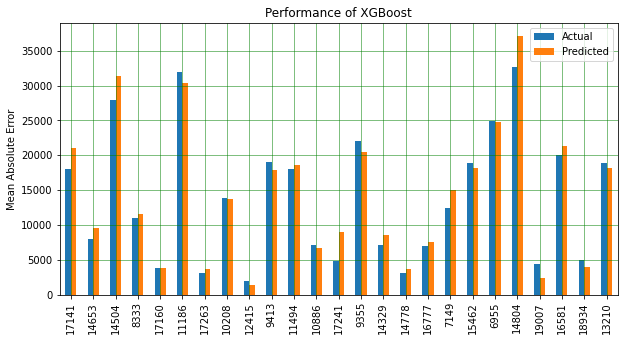

In [21]:
y_pred = XGB.predict(Xtest)
df_check = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of XGBoost')
plt.ylabel('Mean Absolute Error')
plt.savefig('XGBoost-Performance.jpg')
plt.show()

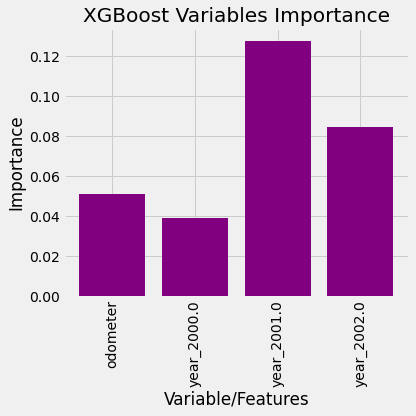

In [22]:
importances = XGB.feature_importances_
features=Xtrain.columns
importances = importances[importances!=0]
importances = importances[importances > 0.03]
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'),color = 'purple')
# Tick labels for x axis
plt.xticks(x_values, features[0:len(x_values)], rotation=(90))
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable/Features')
plt.title('XGBoost Variables Importance')
plt.tight_layout()
plt.show()

In [ ]:
# R squared score + MSE evaluation 